# Subsetting Cordex data 

In [ ]:
# Subsetting CORDEX Data
import xarray as xr
import os
import glob

# Function to subset a single NetCDF file by region
def subset_netcdf_by_region(nc_file, lat_min, lat_max, lon_min, lon_max, output_nc):
    # Load the NetCDF file as an xarray Dataset
    dataset = xr.open_dataset(nc_file)

    # Dynamically identify the coordinate or variable names for latitude and longitude
    lat_name = [name for name in dataset.variables if 'lat' in name.lower()][0]
    lon_name = [name for name in dataset.variables if 'lon' in name.lower()][0]

    # Subset the dataset for the given region using the identified latitude and longitude
    subset = dataset.where(
        (dataset[lat_name] >= lat_min) & (dataset[lat_name] <= lat_max) &
        (dataset[lon_name] >= lon_min) & (dataset[lon_name] <= lon_max),
        drop=True
    )

    # Ensure lat and lon variables are retained but avoid duplication
    if 'lat' not in subset.variables:
        subset['lat'] = dataset['lat']
    if 'lon' not in subset.variables:
        subset['lon'] = dataset['lon']

    # Drop problematic variables like time_bnds
    if 'time_bnds' in subset.variables:
        subset = subset.drop_vars('time_bnds')

    # Copy global attributes from the original dataset
    subset.attrs = dataset.attrs

    # Ensure all variable-level metadata is preserved
    for var in subset.data_vars:
        subset[var].attrs = dataset[var].attrs

    # Save the subsetted dataset to a new NetCDF file
    subset.to_netcdf(output_nc, format="NETCDF4")
    print(f"Subsetted NetCDF file saved to {output_nc}")

# Function to process multiple NetCDF files
def subset_multiple_netcdfs(input_dir, lat_min, lat_max, lon_min, lon_max, output_dir):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all NetCDF files from the input directory
    nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

    for nc_file in nc_files:
        # Generate output file name
        output_nc = os.path.join(output_dir, os.path.basename(nc_file))

        # Subset the NetCDF file
        subset_netcdf_by_region(nc_file, lat_min, lat_max, lon_min, lon_max, output_nc)

# Inputs
input_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\Subsetting\RAW data\RCP 8.5"  # Directory containing NetCDF files
output_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\Subsetting\Subsetted Data\rcp8.5"  # Directory to save subsetted NetCDF files
lat_min, lat_max = 21.0, 26.0  # Adjust these to match your region of interest
lon_min, lon_max = 87.0, 93.0  # Adjust these to match your region of interest

# Subset all NetCDF files in the input directory
subset_multiple_netcdfs(input_dir, lat_min, lat_max, lon_min, lon_max, output_dir)


# Loading Timeseries from APHRODYTE

## Loadin Station Locations

In [ ]:
# Extract coordinates from the csv
import glob
from netCDF4 import Dataset
import pandas as pd
import numpy as np

# Load the list of cities from the CSV file
cities_data = pd.read_csv(r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\BIAS CORRECTION\Selected_Stations_Bangladesh.csv")

# Loop through each row in the DataFrame
for index, row in cities_data.iterrows():
    # Access columns by their names
    city_name = row['Name']
    city_latitude = row['Latitude']
    city_longitude = row['Longitude']

    # Print the values for clarity
    print(f"City: {city_name}, Latitude: {city_latitude}, Longitude: {city_longitude}")

print(data.variables.keys())



## Loading the Time-seris

In [ ]:
import glob
from netCDF4 import Dataset
import pandas as pd
import os

# Step 1: Collect all the years from the NetCDF files
files = glob.glob(r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Subsetting\Subsetted Data")
print(f"Files detected: {len(files)}")

all_years = []
for file in files:
    try:
        data = Dataset(file, 'r')
        time_units = data.variables['time'].units
        year = int(time_units.split()[2][:4])  # Extract year
        all_years.append(year)
        data.close()
    except Exception as e:
        print(f"Error processing file {file}: {e}")

if not all_years:
    raise ValueError("No valid NetCDF files found.")

# Step 2: Load city data
cities_data = pd.read_csv(r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\BIAS CORRECTION\Selected_Stations_Bangladesh.csv")
print(f"Cities loaded: {len(cities_data)} cities")

# Step 3: Process each city and save separate CSV files
for index, row in cities_data.iterrows():
    city_name = row['Name']
    city_latitude = row['Latitude']
    city_longitude = row['Longitude']
    print(f"Processing city: {city_name}")

    # Prepare a list to store data for the city
    city_data = []

    for yr in sorted(all_years):
        file_path = rf"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\APHRODYTE Data\APHRO_Data_1971-2005\APHRO_MA_050deg_V1101.{yr}.nc"
        
        if not os.path.exists(file_path):
            print(f"Warning: File for year {yr} not found. Skipping...")
            continue

        try:
            data = Dataset(file_path, 'r')

            # Extract latitude, longitude, and precipitation data
            lat = data.variables['latitude'][:]
            lon = data.variables['longitude'][:]
            precip = data.variables['precip']  # Assuming 'precip' is the variable name

            # Find the closest grid point
            closest_lat = (lat - city_latitude) ** 2
            closest_lon = (lon - city_longitude) ** 2
            min_index_lat = closest_lat.argmin()  # Closest latitude index
            min_index_lon = closest_lon.argmin()  # Closest longitude index

            # Define the date range for the year
            time_var = data.variables['time']
            dates = pd.date_range(start=f"{yr}-01-01", periods=len(time_var), freq='D')

            # Extract precipitation data for the closest grid point
            for t_index, date in enumerate(dates):
                precip_value = precip[t_index, min_index_lat, min_index_lon]
                city_data.append([date, precip_value])

            data.close()
        except Exception as e:
            print(f"Error processing year {yr} for {city_name}: {e}")
            continue

    # Step 4: Save city data to a separate CSV file
    city_df = pd.DataFrame(city_data, columns=["Time", "Precipitation"])
    city_file = f"{city_name}_Precipitation.csv"
    city_df.to_csv(city_file, index=False)
    print(f"Saved data for {city_name} to {city_file}")


## Converting the time-series to ASCII format

In [ ]:
import os
import pandas as pd
import numpy as np

# Define input CSV folder and output ASCII folder
csv_folder = r"d:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\BIAS CORRECTION\observed\CSV CITIES"
output_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Codes\NetCDF Preprocessing\BIAS CORRECTION\observed\ASCII Cities Mains"

os.makedirs(output_folder, exist_ok=True)

# Function to convert CSV to ASCII format
def csv_to_ascii(csv_file, output_file):
    # Load CSV file
    data = pd.read_csv(csv_file)

    # Replace 0.0 and small values near zero (less than 0.01) with -99.0
    data['Precipitation'] = data['Precipitation'].apply(lambda x: -99.0 if (x == 0.0 or abs(x) < 0.01 or np.isnan(x)) else x)

    # Extract time and precipitation columns
    time_values = data['Time'].tolist()
    precip_values = data['Precipitation'].tolist()

    # Open the ASCII file for writing
    with open(output_file, 'w') as ascii_file:
        # Write the first line with the starting date
        ascii_file.write(f"{time_values[0]}\n")
        
        # Write the precipitation data line by line
        for value in precip_values:
            ascii_file.write(f"{value}\n")

# Loop through all CSV files and convert to ASCII
for csv_filename in os.listdir(csv_folder):
    if csv_filename.endswith('.csv'):
        csv_file_path = os.path.join(csv_folder, csv_filename)
        ascii_filename = os.path.splitext(csv_filename)[0] + '_Precipitation.txt'
        ascii_file_path = os.path.join(output_folder, ascii_filename)

        # Convert CSV to ASCII
        csv_to_ascii(csv_file_path, ascii_file_path)

print("Conversion completed! Check the output ASCII files.")


## Loading Eleveations

In [ ]:
import requests

def get_elevation(lat, lon):
    """
    Fetches elevation for the given latitude and longitude using Open Elevation API.
    """
    url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            elevation = response.json()['results'][0]['elevation']
            return elevation
        else:
            print(f"Error: Unable to fetch elevation for {lat}, {lon}. HTTP {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching elevation: {e}")
        return None

# Define city coordinates
cities = {
    "Rajshahi": (24.3745, 88.6042),
    "Rangpur": (25.7439, 89.2752),
    "Sylhet": (24.8898, 91.8698),
    "Dhaka": (23.8103, 90.4125),
    "Khulna": (22.8456, 89.5403)
}

# Fetch and display elevations
print("City Elevations (in meters):")
for city, (lat, lon) in cities.items():
    elevation = get_elevation(lat, lon)
    if elevation is not None:
        print(f"{city}: {elevation:.2f} meters")
    else:
        print(f"{city}: Elevation data not available")


# ASCII to CSV

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import os

# Define the directories
input_directory = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\SPI Power Transform\MIROC-MIROC5\PowerTransformation\RCP8.5"
output_directory = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data\RCP8.5_sim_PT\Daily"

# Ensure the output directory exists
if not os.path.exists(output_directory):
    print(f"The directory {output_directory} does not exist. Creating it now...")
    os.makedirs(output_directory)

# Get a list of all .txt files in the input directory
txt_files = [f for f in os.listdir(input_directory) if f.endswith('.txt')]

# Create a mapping from PCP code to station name
station_mapping = {
    'PCP0001': 'Dhaka',
    'PCP0002': 'Khulna',
    'PCP0003': 'Rajshahi',
    'PCP0004': 'Rangpur',
    'PCP0005': 'Sylhet'
}

# Loop through all the .txt files and process each one
for txt_file in txt_files:
    # Construct the full path for the input .txt file
    input_file_path = os.path.join(input_directory, txt_file)
    
    # Extract the base file name (without extension)
    base_name = os.path.splitext(txt_file)[0]
    
    # The first part of base_name (before an underscore) might be "PCP0001", etc.
    # If your naming scheme is exactly PCP0001.txt, PCP0002.txt, etc., you can just use base_name directly.
    # Otherwise, split on underscore if needed:
    file_prefix = base_name.split('_')[0]  # e.g., "PCP0001"
    
    # Look up the station name in the dictionary
    if file_prefix in station_mapping:
        station_name = station_mapping[file_prefix]
    else:
        # Fallback if not in dictionary
        station_name = base_name  # or "UnknownStation"
    
    # Define the output CSV path using the station name
    output_csv = os.path.join(output_directory, f"{station_name}_precipitation_data.csv")
    
    print(f"Processing {input_file_path}... Output will be saved to {output_csv}")
    
    # Read the .txt file
    with open(input_file_path, 'r') as file:
        # Read the first line (start date) and convert to datetime
        start_date_str = file.readline().strip()
        start_date = datetime.strptime(start_date_str, '%Y%m%d')
        
        # Read the remaining lines as precipitation data
        precipitation_values = []
        for line in file:
            # Parse the precipitation value (skip empty/invalid lines)
            try:
                precip_value = float(line.strip())
                precipitation_values.append(precip_value)
            except ValueError:
                continue
    
    # Generate the corresponding date range
    date_range = [start_date + timedelta(days=i) for i in range(len(precipitation_values))]
    
    # Create a DataFrame with Date and Precipitation columns
    df = pd.DataFrame({
        'Date': date_range,
        'Precipitation': precipitation_values
    })
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    
    print(f"Data has been successfully converted to CSV format and saved as {output_csv}")


## Format and Missing Data Correction
The below code compares the simulated data with observed data to check if any data is missing. Then it, finds the missing data, interpolates, renames the *Time* column to *Date* to match with the observed data format. This also corrects outliers


### Fixing the RCP8.5 Data


In [2]:
import pandas as pd
import numpy as np
import os
import glob

# **User Input: Folder Paths**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\uncorrected"  # Change this to your actual folder path
output_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\Interpolated_outlierCapped"  # Change this to your actual output folder path

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# **Process Each CSV File**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # **Step 1: Fill in missing dates**
        date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
        df_full = pd.DataFrame({'Date': date_range})
        df_filled = df_full.merge(df, on='Date', how='left')

        # **Step 2: Interpolate missing precipitation values**
        df_filled['Precipitation'] = df_filled['Precipitation'].interpolate(method='linear')

        # **Step 3: Apply 90% Outlier Capping**
        percentile_90 = np.percentile(df_filled['Precipitation'].dropna(), 90)

        # Replace values above the 90th percentile with the threshold
        df_filled['Precipitation'] = np.where(df_filled['Precipitation'] > percentile_90, percentile_90, df_filled['Precipitation'])

        # **Step 4: Save the processed CSV file**
        output_file = os.path.join(output_folder, os.path.basename(file_path))
        df_filled.to_csv(output_file, index=False)
        print(f"✅ Processed file saved: {output_file}")

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

print(f"\n🎉 All files processed! Cleaned data saved in {output_folder}")


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\uncorrected
✅ Processed file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\Interpolated_outlierCapped\Dhaka_precipitation_data.csv
✅ Processed file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\Interpolated_outlierCapped\Khulna_precipitation_data.csv
✅ Processed file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\Interpolated_outlierCapped\Rajshahi_precipitation_data.csv
✅ Processed file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Outpu

### Daily to Monthly Aggregation

In [ ]:
import pandas as pd
import os
import glob

# **User Input: Folder Paths**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\02. Interpolated_outlierCapped"  # Change this to your actual folder path
output_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly"  # Change this to your actual output folder path

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# **Process Each CSV File**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # **Convert Daily to Monthly Total**
        df['YearMonth'] = df['Date'].dt.to_period('M')  # Extract Year-Month
        df_monthly = df.groupby('YearMonth')['Precipitation'].sum().reset_index()

        # Convert 'YearMonth' back to datetime format for proper plotting
        df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

        # Rename columns for clarity
        df_monthly.rename(columns={'YearMonth': 'Date', 'Precipitation': 'Monthly_Precipitation'}, inplace=True)

        # **Save the processed CSV file**
        output_file = os.path.join(output_folder, os.path.basename(file_path))
        df_monthly.to_csv(output_file, index=False)
        print(f"✅ Processed monthly file saved: {output_file}")

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

print(f"\n🎉 All files processed! Monthly data saved in {output_folder}")


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Daily\02. Interpolated_outlierCapped
✅ Processed monthly file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly\Dhaka_precipitation_data.csv
✅ Processed monthly file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly\Khulna_precipitation_data.csv
✅ Processed monthly file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly\Rajshahi_precipitation_data.csv
✅ Processed monthly file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5

### Monsoon Precipitation

In [5]:
import pandas as pd
import os
import glob

# **User Input: Folder Paths**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly"  # Change this to your actual folder path
output_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon"  # Change this to your actual output folder path

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# **Process Each CSV File**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract Year and Month
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month

        # **Filter only Monsoon Season (June to September)**
        df_monsoon = df[df['Month'].isin([6, 7, 8, 9])]

        # **Calculate Total Monsoon Precipitation per Year**
        df_monsoon_yearly = df_monsoon.groupby('Year')['Monthly_Precipitation'].sum().reset_index()

        # Rename columns for clarity
        df_monsoon_yearly.rename(columns={'Monthly_Precipitation': 'Monsoon_Precipitation'}, inplace=True)

        # **Save the processed CSV file**
        output_file = os.path.join(output_folder, os.path.basename(file_path))
        df_monsoon_yearly.to_csv(output_file, index=False)
        print(f"✅ Processed monsoon precipitation file saved: {output_file}")

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

print(f"\n🎉 All files processed! Monsoon seasonal data saved in {output_folder}")


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly
✅ Processed monsoon precipitation file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon\Dhaka_precipitation_data_monthly.csv
✅ Processed monsoon precipitation file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon\Khulna_precipitation_data_monthly.csv
✅ Processed monsoon precipitation file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon\Rajshahi_precipitation_data_monthly.csv
✅ Processed monsoon precipitation file saved: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes

### Trends in Monthly

📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly
📊 Styled precipitation trend plot saved as D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly\Monthly_Precipitation_Horizontal_Legend.png


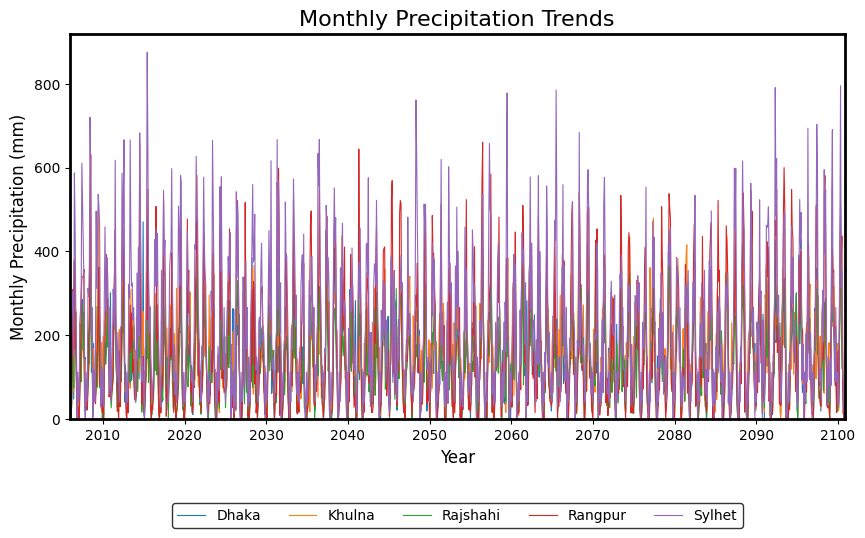

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# **User Input: Folder Path**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly"

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Track min and max dates for proper X-axis range
all_dates = []

# **Process Each CSV File and Plot**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Track dates for X-axis alignment
        all_dates.extend(df['Date'].tolist())

        # Extract city name from the filename
        city_name = os.path.basename(file_path).split("_")[0]

        # Plot trend line (NO DOTS, THINNER LINES)
        plt.plot(df['Date'], df['Monthly_Precipitation'], linestyle='-', linewidth=0.8, label=city_name)

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

# **Ensure X-Axis Covers the Full Timeline**
plt.xlim(min(all_dates), max(all_dates))

# **Fix Y-Axis to Remove Unnecessary Gaps**
plt.ylim(bottom=0)  # Start Y-Axis at 0

# **Customize the Plot**
plt.xlabel("Year", fontsize=12, fontweight='light')
plt.ylabel("Monthly Precipitation (mm)", fontsize=12, fontweight='light')
plt.title("Monthly Precipitation Trends", fontsize=16, fontweight='light')

# **Thicker Borders**
for spine in ax.spines.values():
    spine.set_linewidth(2)

# **Legend Formatting - Placed Horizontally Below the Plot**
plt.legend(
    title="",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # Moves legend below the plot
    ncol=len(csv_files),  # Places all legends in a single row
    fontsize=10,
    frameon=True,
    edgecolor='black'
)

# **Remove Background Grid**
plt.grid(False)

# **Rotate X-Ticks for Clarity**
plt.xticks(rotation=0)

# **Save the Plot**
output_plot = os.path.join(input_folder, "Monthly_Precipitation_Horizontal_Legend.png")
plt.savefig(output_plot, dpi=300, bbox_inches='tight')
print(f"📊 Styled precipitation trend plot saved as {output_plot}")

# **Show the Plot**
plt.show()


### Trends in Monsoon 

📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon
📊 Trend plot saved as D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon\Monsoon_Precipitation_Trends.png


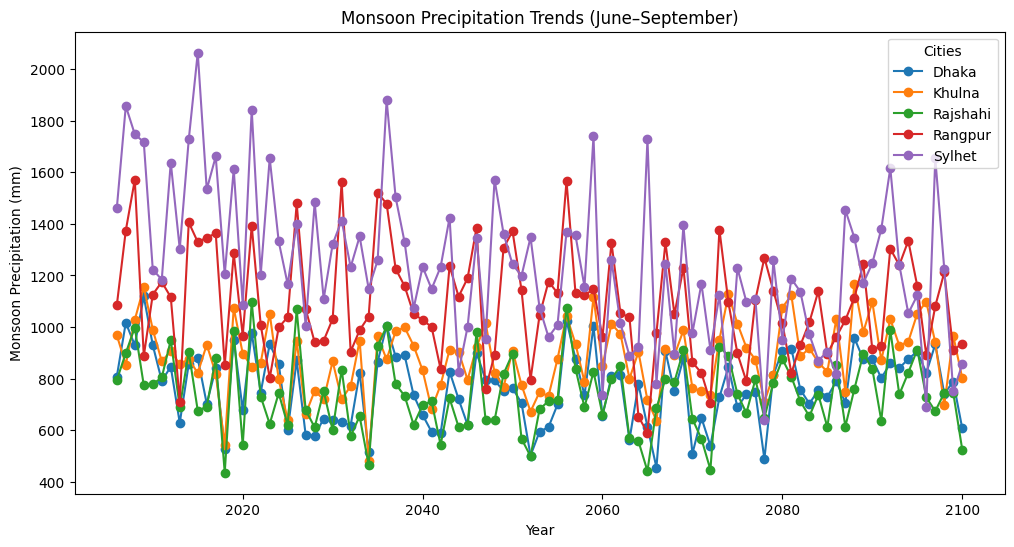

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# **User Input: Folder Path**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon"  # Change this to your actual folder path

# **Legend Location Options**
legend_location = "upper right"  # Change to "upper left", "lower right", etc.
show_grid = False  # Set to True if you want grid lines, False to remove them

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# Initialize the plot
plt.figure(figsize=(12, 6))

# **Process Each CSV File and Plot**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Ensure 'Year' column is numeric
        df['Year'] = pd.to_numeric(df['Year'])

        # Extract city name from the filename (Assuming format: "CityName_Precipitation.csv")
        city_name = os.path.basename(file_path).split("_")[0]  # Extract first part before the first "_"

        # Plot the trend
        plt.plot(df['Year'], df['Monsoon_Precipitation'], marker='o', linestyle='-', label=city_name)

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

# **Customize the Plot**
plt.xlabel("Year")
plt.ylabel("Monsoon Precipitation (mm)")
plt.title("Monsoon Precipitation Trends (June–September)")

# **Moveable Legend**
plt.legend(title="Cities", loc=legend_location)

# **Remove or Show Grid**
plt.grid(show_grid)

# **Save the Plot**
output_plot = os.path.join(input_folder, "Monsoon_Precipitation_Trends.png")
plt.savefig(output_plot, dpi=300)
print(f"📊 Trend plot saved as {output_plot}")

# **Show the Plot**
plt.show()


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon
📊 Styled monsoon precipitation trend plot saved as D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon\Monsoon_Precipitation_Horizontal_Legend.png


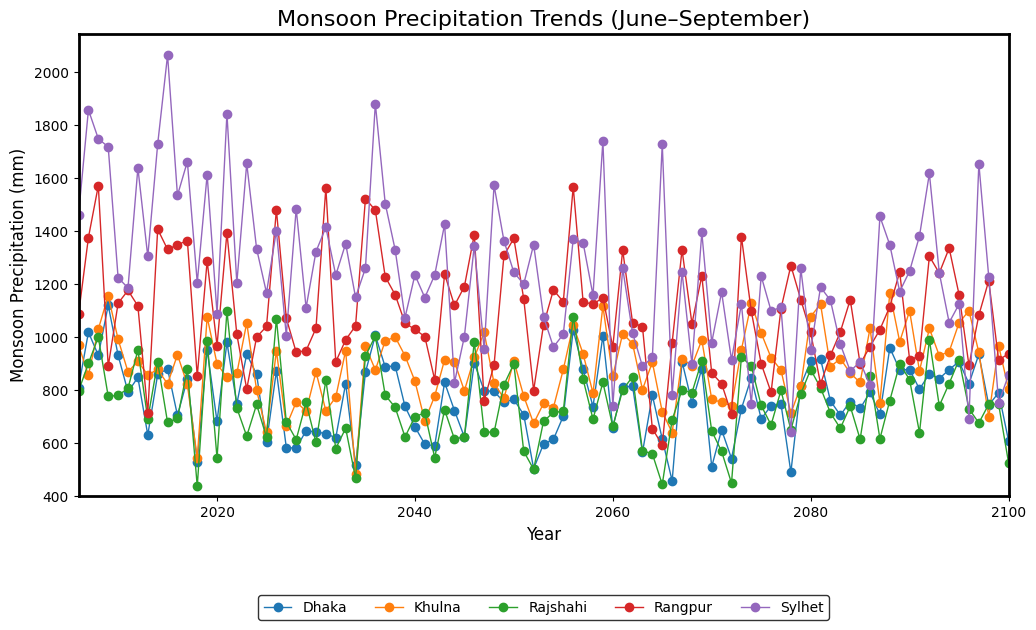

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# **User Input: Folder Path**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monsoon"

# Get all CSV files in the input folder
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Track min and max years for proper X-axis alignment
all_years = []

# **Process Each CSV File and Plot**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Ensure 'Year' column is numeric
        df['Year'] = pd.to_numeric(df['Year'])
        
        # Track years for X-axis range
        all_years.extend(df['Year'].tolist())

        # Extract city name from the filename
        city_name = os.path.basename(file_path).split("_")[0]

        # Plot the trend (KEEP DOTS AND LINES)
        plt.plot(df['Year'], df['Monsoon_Precipitation'], marker='o', linestyle='-', linewidth=1, label=city_name)

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

# **Ensure X-Axis Covers the Full Timeline**
plt.xlim(min(all_years), max(all_years))

# **Fix Y-Axis to Start from 400mm**
plt.ylim(400, None)  # Start Y-Axis at 400mm

# **Customize the Plot**
plt.xlabel("Year", fontsize=12, fontweight='light')
plt.ylabel("Monsoon Precipitation (mm)", fontsize=12, fontweight='light')
plt.title("Monsoon Precipitation Trends (June–September)", fontsize=16, fontweight='light')

# **Thicker Borders**
for spine in ax.spines.values():
    spine.set_linewidth(2)

# **Legend Formatting - Placed Horizontally Below the Plot**
plt.legend(
    title="",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # Moves legend below the plot
    ncol=len(csv_files),  # Places all legends in a single row
    fontsize=10,
    frameon=True,
    edgecolor='black'
)

# **Remove Background Grid**
plt.grid(False)

# **Rotate X-Ticks for Clarity**
plt.xticks(rotation=0)

# **Save the Plot**
output_plot = os.path.join(input_folder, "Monsoon_Precipitation_Horizontal_Legend.png")
plt.savefig(output_plot, dpi=300, bbox_inches='tight')
print(f"📊 Styled monsoon precipitation trend plot saved as {output_plot}")

# **Show the Plot**
plt.show()


##  McKandal Test

In [41]:
import pandas as pd
import numpy as np
import os
import glob
from pymannkendall import original_test  # Install using: pip install pymannkendall

# **USER INPUT: Folder Path for Monthly Data**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly"  # Change this to the actual path where CSVs are stored
output_csv_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\McKandall Test/test_results.csv"  # Change this output path

# **Get all CSV files in the input folder**
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# **Initialize a list to store results**
results = []

# **Process Each CSV File and Apply Mann-Kendall Test**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Ensure 'Date' is in datetime format and extract the 'Year'
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year

        # Extract city name from the filename
        city_name = os.path.basename(file_path).split("_")[0]

        # Aggregate by Year (if monthly data exists, sum up precipitation)
        annual_precipitation = df.groupby('Year')['Monthly_Precipitation'].sum()

        # Perform the Mann-Kendall Test
        mk_result = original_test(annual_precipitation)

        # Extract trend values
        trend = mk_result.trend
        z_value = mk_result.z
        p_value = mk_result.p
        tau = mk_result.Tau

        # Categorize the trend based on significance level (p-value)
        significance = "No Trend"
        if p_value < 0.05 and trend == "increasing":
            significance = "Increasing"
        elif p_value < 0.05 and trend == "decreasing":
            significance = "Decreasing"

        # Append results to the list
        results.append([city_name, significance, z_value, p_value, tau])

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

# **Convert results into a DataFrame**
df_results = pd.DataFrame(results, columns=["City", "Trend", "Z-Value", "P-Value", "Tau"])

# **Save the Results to CSV**
df_results.to_csv(output_csv_path, index=False)
print(f"📊 Trend analysis results saved to {output_csv_path}")

# **Display the results**
print(df_results)


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly
📊 Trend analysis results saved to D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\McKandall Test/test_results.csv
       City       Trend   Z-Value   P-Value       Tau
0     Dhaka  Increasing  2.548013  0.010834  0.176754
1    Khulna  Increasing  3.687497  0.000226  0.255702
2  Rajshahi  Increasing  3.257025  0.001126  0.225877
3   Rangpur    No Trend  1.870653  0.061393  0.129825
4    Sylhet  Decreasing -3.484922  0.000492 -0.241667


# SPI Calculation

This code will turn the monthly dataset in a format compatible with R-Studio

In [42]:
import pandas as pd
import os
import glob

# **USER INPUT: Folder Path for Monthly Data**
input_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly"  # Change this to your folder path
output_folder = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\SPI Calculation\Monthly Data for SPI"  # Change this to your desired output folder

# **Ensure the output folder exists**
os.makedirs(output_folder, exist_ok=True)

# **Get all CSV files in the input folder**
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
print(f"📂 Found {len(csv_files)} CSV files in {input_folder}")

# **Process Each CSV File**
for file_path in csv_files:
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract Year and Month
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month

        # Select only the required columns and rename precipitation column
        df_formatted = df[['Year', 'Month', 'Monthly_Precipitation']].rename(columns={'Monthly_Precipitation': 'prcp'})

        # Extract city name from filename
        city_name = os.path.basename(file_path).split("_")[0]

        # Define output file path
        output_file = os.path.join(output_folder, f"{city_name}_Formatted_SPI.csv")

        # Save the formatted file
        df_formatted.to_csv(output_file, index=False)

        print(f"✅ Saved formatted data for {city_name} -> {output_file}")

    except Exception as e:
        print(f"⚠ Error processing {file_path}: {e}")

print("📊 All datasets have been successfully formatted for SPI calculation in R Studio!")


📂 Found 5 CSV files in D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\RCP8.5_sim_PT\Monthly
✅ Saved formatted data for Dhaka -> D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\SPI Calculation\Monthly Data for SPI\Dhaka_Formatted_SPI.csv
✅ Saved formatted data for Khulna -> D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\SPI Calculation\Monthly Data for SPI\Khulna_Formatted_SPI.csv
✅ Saved formatted data for Rajshahi -> D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\SPI Calculation\Monthly Data for SPI\Rajshahi_Formatted_SPI.csv
✅ Saved formatted data for Rangpur -> D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output

# **Mapping**

## CORDEX Plotting


📅 Available Dates: 2001-01-01 00:00:00 to 2005-12-31 00:00:00
✅ Selected Date: 2005-07-01 00:00:00 (Index 1641)
🔍 Min Precip: 0.0, Max Precip: 61.3037109375
❗ Missing Values: 0 out of 168


C:\Users\Asus\AppData\Local\Temp\ipykernel_11468\3964206534.py:90: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clip_mask = bangladesh_mask.unary_union


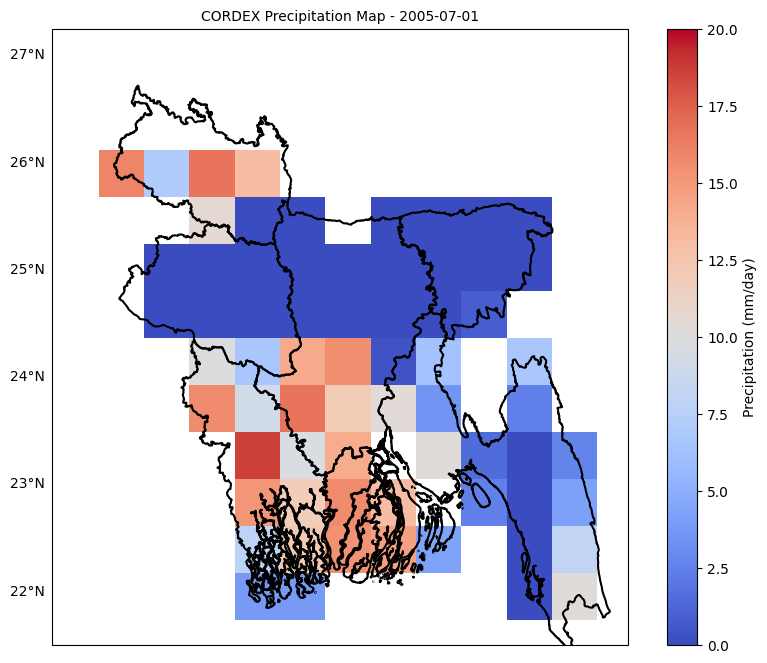

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import numpy.ma as ma  # Mask missing values
from shapely.geometry import box

# === USER INPUT: Normal Lat/Lon for Bangladesh ===
normal_lats = [21.5, 26.7]  # South, North
normal_lons = [87.0, 93.5]  # West, East

# === Convert Normal Lat/Lon to Rotated Lat/Lon ===
rotated_pole = ccrs.RotatedPole(pole_longitude=-123.34, pole_latitude=79.95)
rotated_coords = rotated_pole.transform_points(ccrs.PlateCarree(), np.array(normal_lons), np.array(normal_lats))

# Extract rotated lat/lon
rlats = rotated_coords[:, 1]  # Transformed latitude
rlons = rotated_coords[:, 0]  # Transformed longitude

# === Load CORDEX NetCDF File ===
netcdf_file = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Subsetting\Subsetted Data\pr_WAS-44_MIROC-MIROC5_historical_r1i1p1_SMHI-RCA4_v2_day_20010101-20051231.nc"
ds = Dataset(netcdf_file)

# === Extract Variables ===
rlat = ds.variables["rlat"][:]  # Rotated latitude
rlon = ds.variables["rlon"][:]  # Rotated longitude
time = ds.variables["time"][:]  # Time in CFTime format
precip = ds.variables["pr"][:]  # Precipitation (kg m-2 s-1)

# === Convert Precipitation to mm/day ===
precip = precip * 86400  # Convert from kg/m²/s to mm/day

# === Convert CFTimeIndex to Pandas DateTime ===
time_units = ds.variables["time"].units  # Extract time units
calendar = ds.variables["time"].calendar  # Extract calendar type

time_dates = num2date(time, units=time_units, calendar=calendar)
time_dates = pd.to_datetime([t.strftime("%Y-%m-%d") for t in time_dates])  # Convert to pandas datetime format

# Print available date range
print("\n📅 Available Dates:", time_dates.min(), "to", time_dates.max())

# === USER INPUT: Select a Specific Date ===
date_to_plot = "2005-07-01"  # Change as needed

# === Find the Nearest Available Date ===
if date_to_plot not in time_dates.astype(str).values:
    closest_date = min(time_dates, key=lambda x: abs(pd.Timestamp(date_to_plot) - x))
    print(f"⚠️ Warning: {date_to_plot} not found. Using closest available date: {closest_date}")
    date_to_plot = closest_date

# Get index of the selected date
date_idx = np.where(time_dates == date_to_plot)[0][0]
print(f"✅ Selected Date: {time_dates[date_idx]} (Index {date_idx})")

# === Find Indices for Rotated Lat/Lon Boundaries ===
lat_idx_min = np.abs(rlat - min(rlats)).argmin()
lat_idx_max = np.abs(rlat - max(rlats)).argmin()
lon_idx_min = np.abs(rlon - min(rlons)).argmin()
lon_idx_max = np.abs(rlon - max(rlons)).argmin()

# === Extract Precipitation for Selected Date ===
precip_at_time = precip[date_idx, lat_idx_min:lat_idx_max + 1, lon_idx_min:lon_idx_max + 1]

# === Mask Missing Values ===
precip_at_time = ma.masked_invalid(precip_at_time)

# === Debugging Prints ===
print(f"🔍 Min Precip: {np.nanmin(precip_at_time)}, Max Precip: {np.nanmax(precip_at_time)}")
print(f"❗ Missing Values: {np.isnan(precip_at_time).sum()} out of {precip_at_time.size}")

# === Load Bangladesh Shapefile (Ensure Correct File Path) ===
shapefile_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm1.shp"  # Update path if needed
gdf = gpd.read_file(shapefile_path)

# Filter only Bangladesh (✅ FIXED COLUMN NAME)
bangladesh_gdf = gdf[gdf['NAME_0'] == 'Bangladesh']
bangladesh_boundary = bangladesh_gdf.geometry.values[0]

# === Convert Bangladesh Boundary to Rotated Coordinates ===
bangladesh_gdf = bangladesh_gdf.to_crs(rotated_pole)

# === Clip Rainfall Data to Bangladesh's Shape ===
bbox = box(min(rlons), min(rlats), max(rlons), max(rlats))
bangladesh_mask = bangladesh_gdf.intersection(bbox)
clip_mask = bangladesh_mask.unary_union

# Create 2D meshgrid for clipping
lon_grid, lat_grid = np.meshgrid(rlon[lon_idx_min:lon_idx_max + 1], rlat[lat_idx_min:lat_idx_max + 1])

# Convert grid points to GeoDataFrame
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()), crs=rotated_pole)

# Apply mask to precipitation data
mask = grid_points.intersects(clip_mask)
precip_at_time = np.where(mask.values.reshape(precip_at_time.shape), precip_at_time, np.nan)

# === 🌍 Set Up Correct Projection for CORDEX ===
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': rotated_pole})

# === ✅ FIXED: Draw Clipped Rainfall FIRST, Then Map ===
pcm = ax.pcolormesh(lon_grid, lat_grid, precip_at_time, cmap='coolwarm', shading='auto', vmin=0, vmax=20, transform=rotated_pole, zorder=2)

# === ✅ FIXED: Draw Bangladesh Boundary **Above** Rainfall ===
bangladesh_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, zorder=3)

# === ✅ Adjust Extent for Correct Bounding Box ===
ax.set_extent([min(rlons), max(rlons), min(rlats), max(rlats)], crs=rotated_pole)

# === ✅ Improved Gridlines (Aligned Labels) ===
gridlines = ax.gridlines(draw_labels=False, linewidth=0.0, color='gray', linestyle='--')
gridlines.top_labels = True
gridlines.left_labels = True

# === Add Colorbar & Title ===
cbar = plt.colorbar(pcm, label='Precipitation (mm/day)', location='right', pad=0.05)
plt.title(f'CORDEX Precipitation Map - {date_to_plot}', fontsize=10, fontweight='light')

# === Save the Plot ===
#output_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps"
plt.savefig(os.path.join(output_dir, f'CORDEX_Precip_{date_to_plot}.jpg'))
plt.show()


## APHRODYTE Plotting


📅 Available Dates: 1971-01-01 00:00:00 to 1971-12-31 00:00:00
✅ Selected Date: 1971-07-01 00:00:00 (Index 181)


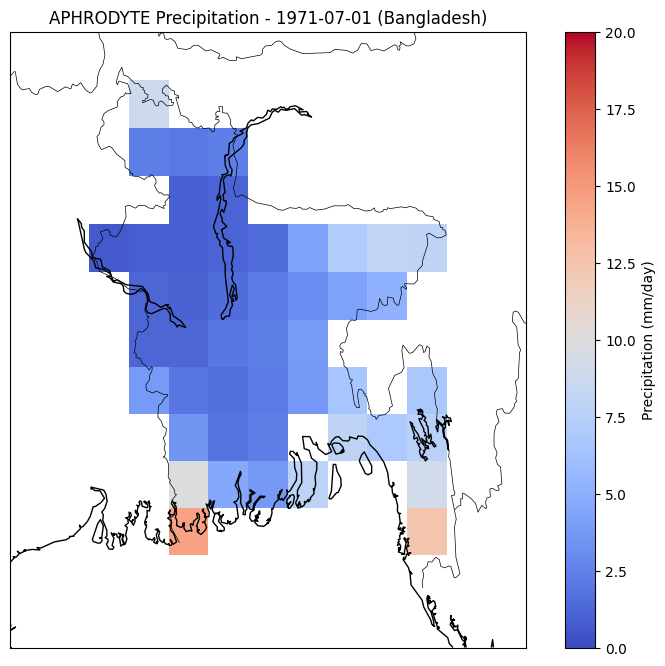

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap
import pandas as pd
import geopandas as gpd
import numpy.ma as ma
from shapely.geometry import box

# === Load APHRODYTE NetCDF File ===
data_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\APHRODYTE Data\APHRO_Data_1971-2005\APHRO_MA_050deg_V1101.1971.nc"
ds = Dataset(data_path)

# === Extract Variables (Corrected for APHRODYTE) ===
lat = ds.variables['latitude'][:]  # Latitude
lon = ds.variables['longitude'][:]  # Longitude
time = ds.variables['time'][:]  # Time
precip = ds.variables['precip'][:]  # Precipitation (mm/day)

# === Convert Time to Pandas Date Format ===
time_units = ds.variables["time"].units  # Extract time units
calendar = ds.variables["time"].__dict__.get("calendar", "standard")  
time_dates = num2date(time, units=time_units, calendar=calendar)
time_dates = pd.to_datetime([t.strftime("%Y-%m-%d") for t in time_dates])

# Print available date range
print("\n📅 Available Dates:", time_dates.min(), "to", time_dates.max())

# === USER INPUT: Select a Specific Date ===
date_to_plot = "1971-07-01"  # Your specified date

# === Find the Nearest Available Date ===
if date_to_plot not in time_dates.astype(str).values:
    closest_date = min(time_dates, key=lambda x: abs(pd.Timestamp(date_to_plot) - x))
    print(f"⚠️ Warning: {date_to_plot} not found. Using closest available date: {closest_date}")
    date_to_plot = closest_date

# Get index of the selected date
date_idx = np.where(time_dates == date_to_plot)[0][0]
print(f"✅ Selected Date: {time_dates[date_idx]} (Index {date_idx})")

# === Extract Precipitation for Selected Date ===
precip_at_time = precip[date_idx, :, :]  # Extract the precipitation data for the selected date

# === Load Bangladesh Shapefile ===
shapefile_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm0.shp"
gdf = gpd.read_file(shapefile_path)
bangladesh_gdf = gdf[gdf['NAME_0'] == 'Bangladesh']
bangladesh_boundary = bangladesh_gdf.geometry.values[0]

# === Create 2D Grids of Longitude and Latitude ===
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Convert 1D arrays to 2D grids

# Convert grid points to GeoDataFrame
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()), crs="EPSG:4326")

# Apply mask to precipitation data
mask = grid_points.intersects(bangladesh_boundary)
precip_at_time = np.where(mask.values.reshape(precip_at_time.shape), precip_at_time, np.nan)

# === Set Up Basemap for Bangladesh ===
mp = Basemap(projection='merc',
             llcrnrlon=87, llcrnrlat=20.5, 
             urcrnrlon=93.5, urcrnrlat=27,
             resolution='i')

# Convert lat/lon to Basemap coordinates
x, y = mp(lon_grid, lat_grid)

# === Plot the Precipitation Data ===
plt.figure(figsize=(10, 8))
c_scheme = mp.pcolormesh(x, y, precip_at_time, cmap='coolwarm', shading='auto', vmin=0, vmax=20)

# === Add Map Features ===
mp.drawcoastlines()
mp.drawcountries()
bangladesh_gdf.boundary.plot(ax=plt.gca(), edgecolor="black", linewidth=1.5)  # Draw Bangladesh border

# === Add Colorbar & Title ===
cbar = plt.colorbar(c_scheme, label='Precipitation (mm/day)', location='right', pad=0.05)
plt.title(f'APHRODYTE Precipitation - {date_to_plot} (Bangladesh)')

# === Save the Plot ===
output_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps"
plt.savefig(os.path.join(output_dir, f'APHRO_Precip_Bangladesh_{date_to_plot}.jpg'))
plt.show()



📅 Available Dates: 1971-01-01 00:00:00 to 1971-12-31 00:00:00
✅ Selected Date: 1971-07-01 00:00:00 (Index 181)


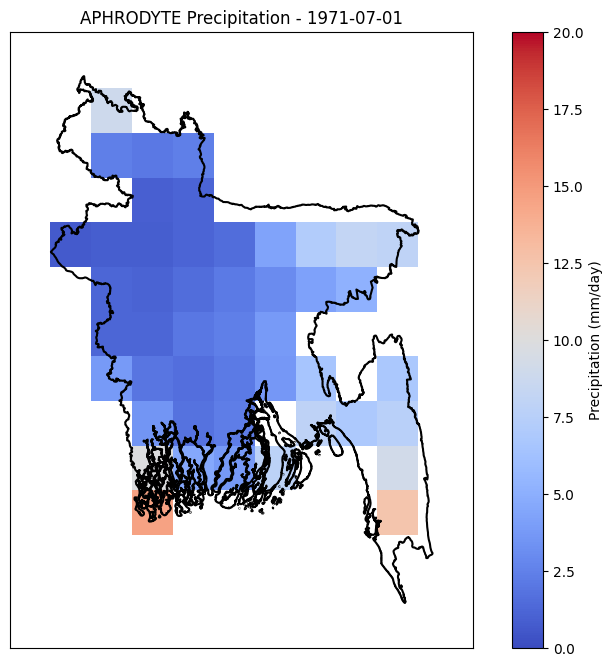

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pandas as pd
import geopandas as gpd
import numpy.ma as ma
from shapely.geometry import box

# === Load APHRODYTE NetCDF File ===
data_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\APHRODYTE Data\APHRO_Data_1971-2005\APHRO_MA_050deg_V1101.1971.nc"
ds = Dataset(data_path)

# === Extract Variables (Corrected for APHRODYTE) ===
lat = ds.variables['latitude'][:]  # Latitude
lon = ds.variables['longitude'][:]  # Longitude
time = ds.variables['time'][:]  # Time
precip = ds.variables['precip'][:]  # Precipitation (mm/day)

# === Convert Time to Pandas Date Format ===
time_units = ds.variables["time"].units  # Extract time units
calendar = ds.variables["time"].__dict__.get("calendar", "standard")  
time_dates = num2date(time, units=time_units, calendar=calendar)
time_dates = pd.to_datetime([t.strftime("%Y-%m-%d") for t in time_dates])

# Print available date range
print("\n📅 Available Dates:", time_dates.min(), "to", time_dates.max())

# === USER INPUT: Select a Specific Date ===
date_to_plot = "1971-07-01"  # Your specified date

# === Find the Nearest Available Date ===
if date_to_plot not in time_dates.astype(str).values:
    closest_date = min(time_dates, key=lambda x: abs(pd.Timestamp(date_to_plot) - x))
    print(f"⚠️ Warning: {date_to_plot} not found. Using closest available date: {closest_date}")
    date_to_plot = closest_date

# Get index of the selected date
date_idx = np.where(time_dates == date_to_plot)[0][0]
print(f"✅ Selected Date: {time_dates[date_idx]} (Index {date_idx})")

# === Extract Precipitation for Selected Date ===
precip_at_time = precip[date_idx, :, :]  # Extract the precipitation data for the selected date

# === Load Bangladesh Shapefile ===
shapefile_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm0.shp"
gdf = gpd.read_file(shapefile_path)
bangladesh_gdf = gdf[gdf['NAME_0'] == 'Bangladesh']
bangladesh_boundary = bangladesh_gdf.geometry.values[0]

# === Create 2D Grids of Longitude and Latitude ===
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Convert 1D arrays to 2D grids

# Convert grid points to GeoDataFrame
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()), crs="EPSG:4326")

# Apply mask to precipitation data
mask = grid_points.intersects(bangladesh_boundary)
precip_at_time = np.where(mask.values.reshape(precip_at_time.shape), precip_at_time, np.nan)

# === 🔍 Adjust the Plot Extent to Focus on Bangladesh Properly ===
min_lon, min_lat, max_lon, max_lat = bangladesh_boundary.bounds  # Get boundary box of Bangladesh

# === 🌍 Plot the Precipitation Data for Bangladesh ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot precipitation data within Bangladesh boundary
c_scheme = ax.pcolormesh(lon_grid, lat_grid, precip_at_time, cmap='coolwarm', shading='auto', vmin=0, vmax=20)

# **Only Plot Bangladesh, No Other Borders**
bangladesh_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)  # Draw Bangladesh border

# Set the extent to properly zoom into Bangladesh
ax.set_xlim([min_lon - 0.5, max_lon + 0.5])  # Adding a buffer for better visualization
ax.set_ylim([min_lat - 0.5, max_lat + 0.5])

# Remove axis labels for a clean look
ax.set_xticks([])
ax.set_yticks([])

# === Add Colorbar & Title ===
cbar = plt.colorbar(c_scheme, label='Precipitation (mm/day)', location='right', pad=0.05)
plt.title(f'APHRODYTE Precipitation - {date_to_plot}')

# === Save the Plot ===
output_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps"
plt.savefig(os.path.join(output_dir, f'APHRO_Precip_Bangladesh_{date_to_plot}.jpg'))
plt.show()



📅 Available Dates: 2005-01-01 00:00:00 to 2005-12-31 00:00:00
✅ Selected Date: 2005-07-01 00:00:00 (Index 181)


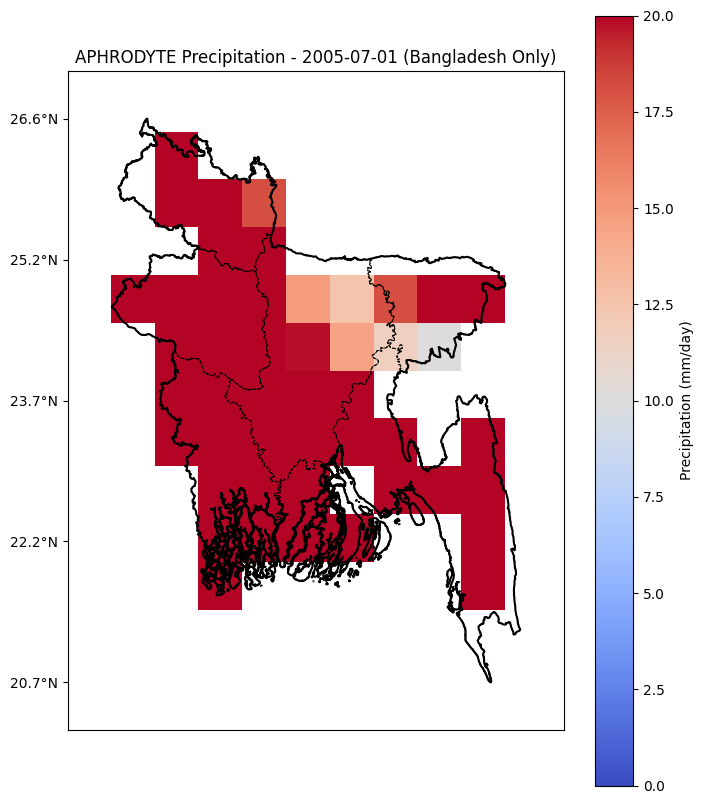

In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pandas as pd
import geopandas as gpd
import numpy.ma as ma
from shapely.geometry import box

# === Load APHRODYTE NetCDF File ===
data_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\APHRODYTE Data\APHRO_Data_1971-2005\APHRO_MA_050deg_V1101.2005.nc"
ds = Dataset(data_path)

# === Extract Variables (Corrected for APHRODYTE) ===
lat = ds.variables['latitude'][:]  # Latitude
lon = ds.variables['longitude'][:]  # Longitude
time = ds.variables['time'][:]  # Time
precip = ds.variables['precip'][:]  # Precipitation (mm/day)

# === Convert Time to Pandas Date Format ===
time_units = ds.variables["time"].units  # Extract time units
calendar = ds.variables["time"].__dict__.get("calendar", "standard")  
time_dates = num2date(time, units=time_units, calendar=calendar)
time_dates = pd.to_datetime([t.strftime("%Y-%m-%d") for t in time_dates])

# Print available date range
print("\n📅 Available Dates:", time_dates.min(), "to", time_dates.max())

# === USER INPUT: Select a Specific Date ===
date_to_plot = "2005-07-01"  # Your specified date

# === Find the Nearest Available Date ===
if date_to_plot not in time_dates.astype(str).values:
    closest_date = min(time_dates, key=lambda x: abs(pd.Timestamp(date_to_plot) - x))
    print(f"⚠️ Warning: {date_to_plot} not found. Using closest available date: {closest_date}")
    date_to_plot = closest_date

# Get index of the selected date
date_idx = np.where(time_dates == date_to_plot)[0][0]
print(f"✅ Selected Date: {time_dates[date_idx]} (Index {date_idx})")

# === Extract Precipitation for Selected Date ===
precip_at_time = precip[date_idx, :, :]  # Extract the precipitation data for the selected date

# === Load Bangladesh Shapefiles (Country & Divisional Borders) ===
country_shapefile = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm0.shp"
division_shapefile = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm1.shp"

bangladesh_gdf = gpd.read_file(country_shapefile)  # Country Boundary
divisions_gdf = gpd.read_file(division_shapefile)  # Division Boundaries

bangladesh_boundary = bangladesh_gdf[bangladesh_gdf['NAME_0'] == 'Bangladesh'].geometry.values[0]

# === Create 2D Grids of Longitude and Latitude ===
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Convert 1D arrays to 2D grids

# Convert grid points to GeoDataFrame
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()), crs="EPSG:4326")

# Apply mask to precipitation data
mask = grid_points.intersects(bangladesh_boundary)
precip_at_time = np.where(mask.values.reshape(precip_at_time.shape), precip_at_time, np.nan)

# === 🔍 Adjust the Plot Extent to Focus on Bangladesh Properly ===
min_lon, min_lat, max_lon, max_lat = bangladesh_boundary.bounds  # Get boundary box of Bangladesh

# === 🌍 Plot the Precipitation Data for Bangladesh ===
fig, ax = plt.subplots(figsize=(8, 10))

# Plot precipitation data within Bangladesh boundary
c_scheme = ax.pcolormesh(lon_grid, lat_grid, precip_at_time, cmap='coolwarm', shading='auto', vmin=0, vmax=20)

# **Only Plot Bangladesh Borders**
bangladesh_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)  # Draw Bangladesh border
divisions_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.7, linestyle="dashed")  # Draw divisional borders

# Set the extent to properly zoom into Bangladesh
ax.set_xlim([min_lon - 0.5, max_lon + 0.5])  # Adding a buffer for better visualization
ax.set_ylim([min_lat - 0.5, max_lat + 0.5])

# === ✅ Add Left Y-Axis Labels ===
ax.set_yticks(np.linspace(min_lat, max_lat, 5))
ax.set_yticklabels([f"{lat:.1f}°N" for lat in np.linspace(min_lat, max_lat, 5)], fontsize=10)

# Remove X-axis labels for a clean look
ax.set_xticks([])

# === Add Colorbar & Title ===
cbar = plt.colorbar(c_scheme, label='Precipitation (mm/day)', location='right', pad=0.05)
plt.title(f'APHRODYTE Precipitation - {date_to_plot} (Bangladesh Only)')

# === Save the Plot ===
output_dir = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps"
plt.savefig(os.path.join(output_dir, f'APHRO_Precip_Bangladesh_{date_to_plot}.jpg'))
plt.show()


# Study Area Map

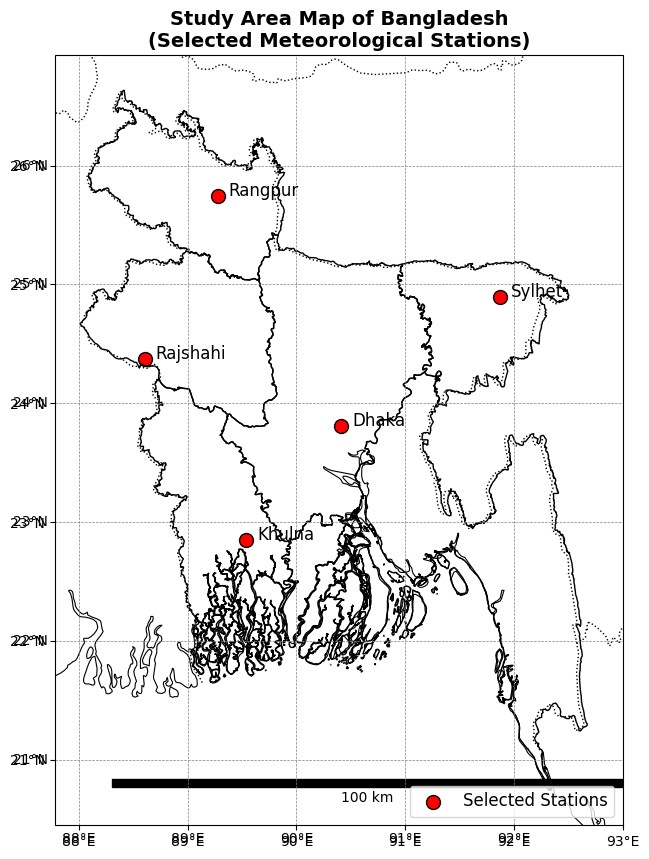

✅ Study Area Map saved at: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\Study_area.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# === File Paths ===
shapefile_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm1.shp"  # Ensure this is the correct path
csv_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\BIAS CORRECTION\Selected_Stations_Bangladesh.csv"  # Ensure correct CSV path

# === Load Bangladesh Shapefile ===
bangladesh_gdf = gpd.read_file(shapefile_path)

# === Load Station Data ===
stations = pd.read_csv(csv_path)
stations_gdf = gpd.GeoDataFrame(stations, 
                                geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude),
                                crs="EPSG:4326")

# === Create Figure and Axes ===
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# === Plot Bangladesh Boundary ===
bangladesh_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# === Plot Divisional Boundaries (If Available) ===
# Use administrative level 1 for divisions if available
# divisional_shapefile_path = "/mnt/data/BGD_adm1.shp"  # Update if needed
# divisional_gdf = gpd.read_file(divisional_shapefile_path)
# divisional_gdf.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.8, linestyle="--")

# === Plot Station Locations ===
ax.scatter(stations["Longitude"], stations["Latitude"], color='red', edgecolor='black', s=100, label='Selected Stations', transform=ccrs.PlateCarree())

# === Add Station Labels ===
for i, row in stations.iterrows():
    ax.text(row["Longitude"] + 0.1, row["Latitude"], row["Name"], fontsize=12, color='black', transform=ccrs.PlateCarree())

# === Map Features ===
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# === Gridlines and Labels ===
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.right_labels = False
gl.top_labels = False
ax.set_xticks(np.arange(88, 93.6, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(21, 27, 1), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# === Add Legend ===
ax.legend(loc='lower right', fontsize=12, frameon=True)

# === Add Scale Bar ===
def scale_bar(ax, location=(0.1, 0.05), length=100):
    """ Adds a scale bar in kilometers """
    import matplotlib.patches as mpatches
    from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
    
    x0, y0 = location
    x1 = x0 + (length / 111)  # Convert to degrees
    scale_bar = mpatches.Rectangle((x0, y0), x1 - x0, 0.01, transform=ax.transAxes, color='black', label=f'{length} km')
    ax.add_patch(scale_bar)
    ax.text(x0 + (x1 - x0) / 2, y0 - 0.02, f'{length} km', transform=ax.transAxes, fontsize=10, ha='center')

scale_bar(ax)

# === Title ===
plt.title("Study Area Map of Bangladesh\n(Selected Meteorological Stations)", fontsize=14, fontweight='bold')

# === Save and Show Map ===
output_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\Study_area.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Study Area Map saved at: {output_path}")


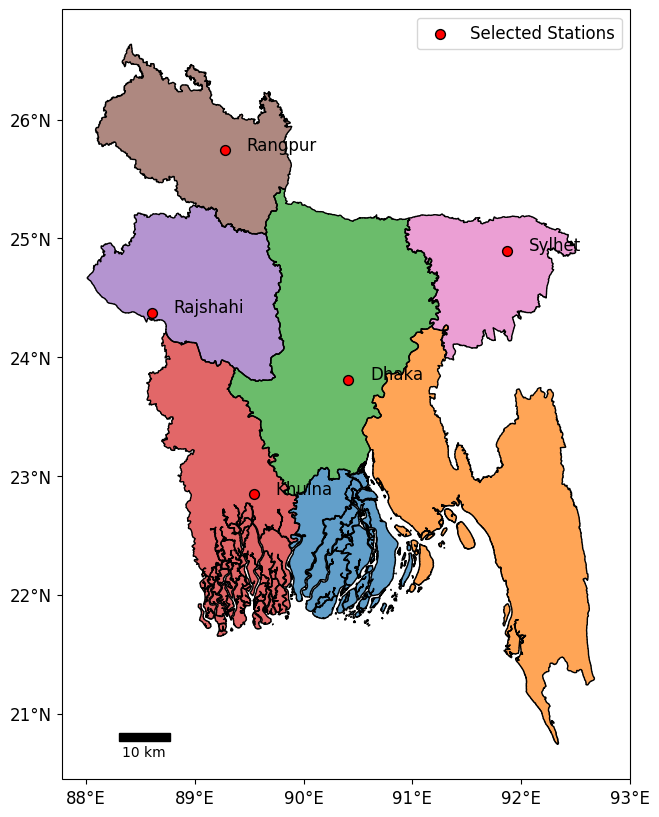

✅ Study Area Map saved at: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\studyarea_final.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# === File Paths ===
bangladesh_shapefile = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm1.shp"  # Bangladesh Shapefile
stations_csv = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\BIAS CORRECTION\Selected_Stations_Bangladesh.csv"  # Selected Stations CSV

# === Load Bangladesh Shapefile ===
bangladesh_gdf = gpd.read_file(bangladesh_shapefile)

# === Load Station Data ===
stations = pd.read_csv(stations_csv)
stations_gdf = gpd.GeoDataFrame(stations, 
                                geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude),
                                crs="EPSG:4326")

# === Create Figure and Axes ===
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# === Apply Watercolor Effect for Bangladesh Divisions ===
colors = list(mcolors.TABLEAU_COLORS.values())  # Get Tableau color palette
bangladesh_gdf.plot(ax=ax, color=colors, alpha=0.7, edgecolor='black', linewidth=0.8, linestyle="dotted", zorder=2)  # Pen-like texture

# === Plot Bangladesh Boundary ===
bangladesh_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle="solid", zorder=3)

# === Plot Station Locations ===
ax.scatter(stations["Longitude"], stations["Latitude"], color='red', edgecolor='black', s=50, label='Selected Stations', transform=ccrs.PlateCarree(), zorder=4)

# === Add Station Labels (Adjusted for spacing) ===
for i, row in stations.iterrows():
    ax.text(row["Longitude"] + 0.2, row["Latitude"], row["Name"], fontsize=12, color='black', transform=ccrs.PlateCarree(), zorder=5)

# === Remove Gridlines ===
ax.grid(False)

# === Adjust X & Y Axis Labels Properly ===
ax.set_xticks(np.arange(88, 93.6, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(21, 27, 1), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(axis='both', which='major', labelsize=12)

# === Add Legend ===
ax.legend(loc='upper right', fontsize=12, frameon=True)

# === Add Scale Bar ===
def scale_bar(ax, location=(0.1, 0.05), length=10):
    """ Adds a scale bar in kilometers """
    x0, y0 = location
    x1 = x0 + (length / 111)  # Convert to degrees
    scale_bar = mpatches.Rectangle((x0, y0), x1 - x0, 0.01, transform=ax.transAxes, color='black', label=f'{length} km')
    ax.add_patch(scale_bar)
    ax.text(x0 + (x1 - x0) / 2, y0 - 0.02, f'{length} km', transform=ax.transAxes, fontsize=10, ha='center')

scale_bar(ax)

# === Title ===

# === Save and Show Map ===
output_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\studyarea_final.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Study Area Map saved at: {output_path}")


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ra

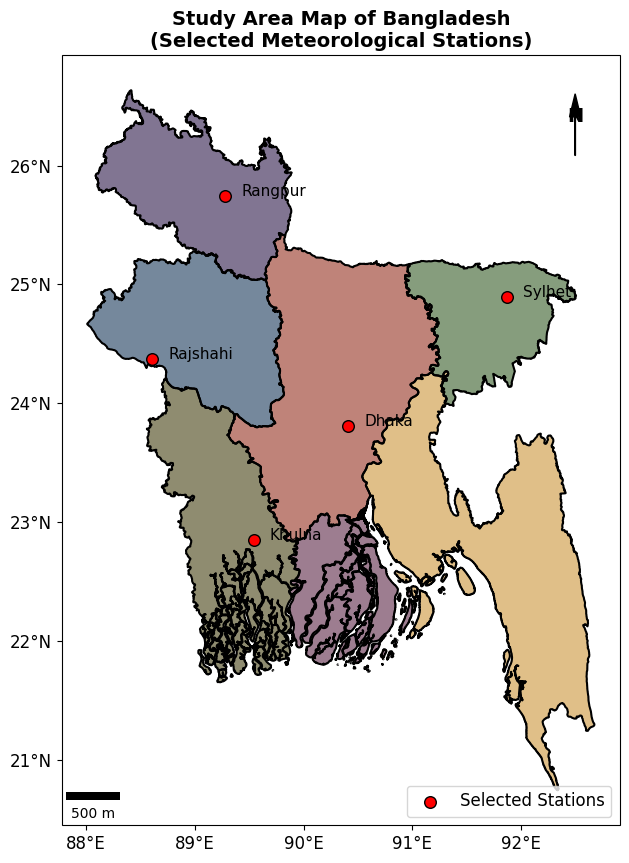

✅ Study Area Map saved at: D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\studyarea_final.png


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar  # ✅ Replaces AnchoredSizeBar
import colorcet as cc  # ✅ GIS-friendly colors
from palettable.cartocolors.qualitative import Antique_10  # ✅ More vibrant colors

# === File Paths ===
bangladesh_shapefile = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\BGD_adm\BGD_adm1.shp"
stations_csv = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\BIAS CORRECTION\Selected_Stations_Bangladesh.csv"

# === Load Bangladesh Shapefile ===
bangladesh_gdf = gpd.read_file(bangladesh_shapefile)

# === Load Station Data ===
stations = pd.read_csv(stations_csv)
stations_gdf = gpd.GeoDataFrame(stations, 
                                geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude),
                                crs="EPSG:4326")

# === Create Figure and Axes ===
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# === Apply Beautiful Watercolor Effect ===
colors = Antique_10.mpl_colors  # ✅ Using a **Carto Colors** palette
bangladesh_gdf.plot(ax=ax, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8, linestyle="dotted", zorder=2)

# === Plot Bangladesh Boundary ===
bangladesh_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, linestyle="solid", zorder=3)

# === Plot Station Locations ===
ax.scatter(stations["Longitude"], stations["Latitude"], color='red', edgecolor='black', s=70, label='Selected Stations', transform=ccrs.PlateCarree(), zorder=4)

# === Add Station Labels (Properly Positioned) ===
for i, row in stations.iterrows():
    ax.text(row["Longitude"] + 0.15, row["Latitude"], row["Name"], fontsize=11, color='black', transform=ccrs.PlateCarree(), zorder=5)

# === Remove Gridlines ===
ax.grid(False)

# === Adjust X & Y Axis Labels Properly ===
ax.set_xticks(np.arange(88, 93.6, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(21, 27, 1), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(axis='both', which='major', labelsize=12)

# === Add Legend ===
ax.legend(loc='lower right', fontsize=12, frameon=True)

# === ✅ **Add Proper GIS-Style Scale Bar** (Now Fixed) ===
scalebar = ScaleBar(1, location='lower left', units="km", scale_loc="bottom", length_fraction=0.1, frameon=False, color="black")
ax.add_artist(scalebar)

# === ✅ **Add North Arrow (More GIS-Friendly)**
ax.annotate('N', xy=(0.92, 0.92), xycoords='axes fraction', fontsize=14, fontweight='bold', ha='center', va='center')
ax.arrow(0.92, 0.87, 0, 0.05, transform=ax.transAxes, color='black', head_width=0.02, head_length=0.03)

# === Title ===
plt.title("Study Area Map of Bangladesh\n(Selected Meteorological Stations)", fontsize=14, fontweight='bold')

# === Save and Show Map ===
output_path = r"D:\Study\Master's\Courses\Climate Modelling\Saiful Sir\Term paper\Term Paper Codes\NetCDF Preprocessing\Output_Plots_Data_code\Creating Maps\studyarea_final.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Study Area Map saved at: {output_path}")
